<a href="https://colab.research.google.com/github/pienight/Machinelearning/blob/master/googlenetmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Connecting to GDrive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
cd /content/gdrive/My Drive/testz

/content/gdrive/My Drive/testz


In [0]:
import os
import random
import shutil


train_rate=0.6
val_rate=0.2
test_rate=0.2
rates=[train_rate,val_rate,test_rate]
base_dir='dataset/jpg'
jpg_list=os.listdir(base_dir)

random.shuffle(jpg_list)

labels=['Daffodil', 'Snowdrop', 'LilyValley', 'Bluebell', 'Crocus', 'Iris', 'Tigerlily', 'Tulip', 'Fritillary',
              'Sunflower', 'Daisy', 'ColtsFoot', 'Dandelion', 'Cowslip', 'Buttercup', 'Windflower', 'Pansy']

def make_set(rates):
    len_ipg_list=len(jpg_list)
    train_index_start=0
    train_index_end=int(len_ipg_list*rates[0])
    val_index_end = int(len_ipg_list * rates[1])+train_index_end
    test_index_end=int(len_ipg_list * rates[2])+val_index_end
    for i in range(17):
        path='data_split/train/'+labels[i]
        if(not os.path.exists(path)):
            os.makedirs(path)
    for i in range(train_index_start,train_index_end):
        jpg_name=jpg_list[i]
        jpg_class=labels[int((int(jpg_name[6:10])-1)/80)]
        dst_path='data_split/train/'+jpg_class+'/'+jpg_name
        shutil.copyfile(os.path.join(base_dir,jpg_list[i]), dst_path)
    for i in range(17):
        path='data_split/val/'+labels[i]
        if(not os.path.exists(path)):
            os.makedirs(path)
    for i in range(train_index_end,val_index_end):
        jpg_name=jpg_list[i]
        jpg_class=labels[int((int(jpg_name[6:10])-1)/80)]
        dst_path='data_split/val/'+jpg_class+'/'+jpg_name
        shutil.copyfile(os.path.join(base_dir,jpg_list[i]), dst_path)
        for i in range(17):
            path = 'data_split/test/' + labels[i]
            if (not os.path.exists(path)):
                os.makedirs(path)
        for i in range(val_index_end, test_index_end):
            jpg_name = jpg_list[i]
            jpg_class = labels[int((int(jpg_name[6:10]) - 1) / 80)]
            dst_path = 'data_split/test/' + jpg_class+'/'+jpg_name
            shutil.copyfile(os.path.join(base_dir, jpg_list[i]), dst_path)
make_set(rates)

In [4]:
from keras.layers import Conv2D,GlobalAveragePooling2D,BatchNormalization,MaxPooling2D,Flatten,Dense,Dropout,Activation
from keras.models import Sequential,Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from matplotlib import pyplot as plt
from keras.applications.inception_v3 import  InceptionV3
from sklearn.metrics import classification_report,confusion_matrix
import numpy as np
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
from matplotlib import pyplot as plt
NB_RES50_LAYERS_TO_FREEZE = 200
input_shape=(500,500,3)
def InceptionV3_model():
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

    x_model = base_model.output

    x_model = GlobalAveragePooling2D(name='globalaveragepooling2d')(x_model)

    x_model = Dense(128, activation='relu', name='fc1_Dense')(x_model)
    x_model = Dropout(0.5, name='dropout_1')(x_model)

    x_model = Dense(64, activation='relu', name='fc2_Dense')(x_model)
    x_model = Dropout(0.5, name='dropout_2')(x_model)
    predictions = Dense(17, activation='softmax', name='output_layer')(x_model)

    model = Model(inputs=base_model.input, outputs=predictions)

    return model
def setup_to_finetune(model):

    for layer in model.layers[:NB_RES50_LAYERS_TO_FREEZE]:
        layer.trainable = False
    for layer in model.layers[NB_RES50_LAYERS_TO_FREEZE:]:
        layer.trainable = True
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['acc'])


model=InceptionV3_model()
setup_to_finetune(model)
model.summary()

Using TensorFlow backend.










Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 500, 500, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 249, 249, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 249, 249, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 249, 249, 32) 0           ba

In [5]:
batch_sizes=64

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1. / 255, rotation_range=20)
train_generator = train_datagen.flow_from_directory(
"data_split/train",  
target_size = (input_shape[0],input_shape[1]),
batch_size = batch_sizes,
class_mode = 'categorical')

validation_generator = val_datagen.flow_from_directory(
"data_split/val",  
target_size = (input_shape[0],input_shape[1]),
batch_size = 32,
class_mode = 'categorical')

filepath = "checkpoint_inceptionv3/weights-improvement-{epoch:04d}-{val_acc:.6f}.hdf5"  
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True,save_weights_only=False, mode='max')
callbacks_list = [checkpoint]
history = model.fit_generator(
    train_generator,
    steps_per_epoch=int(1360*0.7/batch_sizes),
    nb_epoch=50,
    validation_data=validation_generator,
    validation_steps=6, callbacks=callbacks_list, verbose=1)
model.save('inceptionv3_finetune_model.h5')  

Found 817 images belonging to 17 classes.
Found 272 images belonging to 17 classes.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/50
14/14 [==============================] - 113s 8s/step - loss: 2.5635 - acc: 0.1970 - val_loss: 1.7765 - val_acc: 0.4635

Epoch 00001: val_acc improved from -inf to 0.46354, saving model to checkpoint_inceptionv3/weights-improvement-0001-0.463542.hdf5
Epoch 2/50
14/14 [==============================] - 56s 4s/step - loss: 1.6691 - acc: 0.4761 - val_loss: 0.8027 - val_acc: 0.8409

Epoch 00002: val_acc improved from 0.46354 to 0.84091, saving model to checkpoint_inceptionv3/weights-improvement-0002-0.840909.hdf5
Epoch 3/50
14/14 [==============================] - 81s 6s/step - loss: 1.1624 - acc: 0.6412 - val_loss: 0.6117 - val_acc: 0.8523

Epoch 00003: val_acc improved from 0.84091 to 0.85227, saving model to checkpoint_inceptionv3/weights-improvement-0003-0.852273.hdf5
Epoch 4/50
14/14 [==============

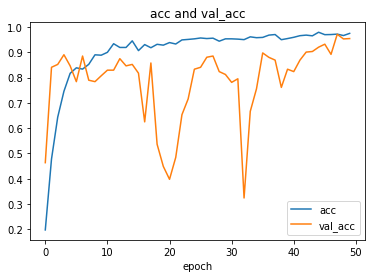

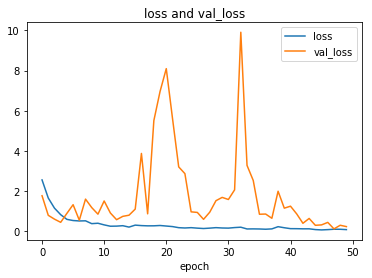

In [6]:
plt.plot(history.history['acc'],label='acc')
plt.plot(history.history['val_acc'],label='val_acc')
plt.title('acc and val_acc')
plt.xlabel('epoch')
plt.legend()
plt.savefig('inceptionv3_acc.jpg')
plt.show()
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.title('loss and val_loss')
plt.xlabel('epoch')
plt.legend()
plt.savefig('inceptionv3_loss.jpg')
plt.show()

In [0]:
from keras.models import load_model
import os
import cv2
model=load_model('/content/gdrive/My Drive/testz/checkpoint_inceptionv3/weights-improvement-0025-0.984375.hdf5')

In [19]:
base_dir='data_split/test/'
img_data=[]
img_label=[]
labels=['Daffodil', 'Snowdrop', 'LilyValley', 'Bluebell', 'Crocus', 'Iris', 'Tigerlily', 'Tulip', 'Fritillary',
              'Sunflower', 'Daisy', 'ColtsFoot', 'Dandelion', 'Cowslip', 'Buttercup', 'Windflower', 'Pansy']
for i in range(17):
    dir=base_dir+labels[i]
    list_dir=os.listdir(dir)
    for k in range(len(list_dir)):
        list_dir[k]=labels[i]+'/'+list_dir[k]
    img_data=img_data+list_dir
    label_temp=[]
    for j in range(len(list_dir)):
        label_temp.append(i)
    img_label=img_label+label_temp

test_y=np.array(img_label)
pre_y=np.zeros((test_y.shape[0],1))
count=0
for img_path in img_data:
    img=cv2.imread(base_dir+img_path)
    img=img / 255.0
    img=cv2.resize(img,(500,500))
    img=img.reshape((1,img.shape[0],img.shape[1],img.shape[2]))
    out=model.predict(img)
    pre_y[count,0]=out.argmax(axis=1)[0]
    count=count+1

def plt_model(true_label,predict,new_label):
    plt.rcParams['figure.figsize'] = (20, 18)
    confusion_mat=confusion_matrix(true_label,predict)
    plt.imshow(confusion_mat,cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks=list(range(confusion_mat.shape[0]))
    plt.xticks(tick_marks,new_label)
    plt.yticks(tick_marks,new_label)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    for first_index in range(confusion_mat.shape[0]):
        for second_index in range(confusion_mat.shape[0]):
            plt.text(first_index, second_index, confusion_mat[second_index][first_index])
    plt.savefig('Confusion_Matrix.jpg')
    plt.show()
new_label=[]
for label in labels:
    new_label.append(label[:])
print(classification_report(test_y,pre_y.ravel(),target_names=new_label))

              precision    recall  f1-score   support

    Daffodil       0.87      0.93      0.90        14
    Snowdrop       1.00      1.00      1.00        17
  LilyValley       1.00      1.00      1.00        19
    Bluebell       0.39      0.63      0.48        19
      Crocus       0.41      0.92      0.57        13
        Iris       1.00      0.93      0.97        15
   Tigerlily       1.00      0.92      0.96        13
       Tulip       0.60      0.20      0.30        15
  Fritillary       1.00      0.94      0.97        17
   Sunflower       1.00      0.95      0.97        20
       Daisy       0.93      0.88      0.90        16
   ColtsFoot       1.00      0.44      0.62        18
   Dandelion       0.59      1.00      0.74        10
     Cowslip       0.00      0.00      0.00        14
   Buttercup       0.95      0.90      0.92        20
  Windflower       1.00      0.71      0.83        14
       Pansy       0.69      1.00      0.82        18

    accuracy              

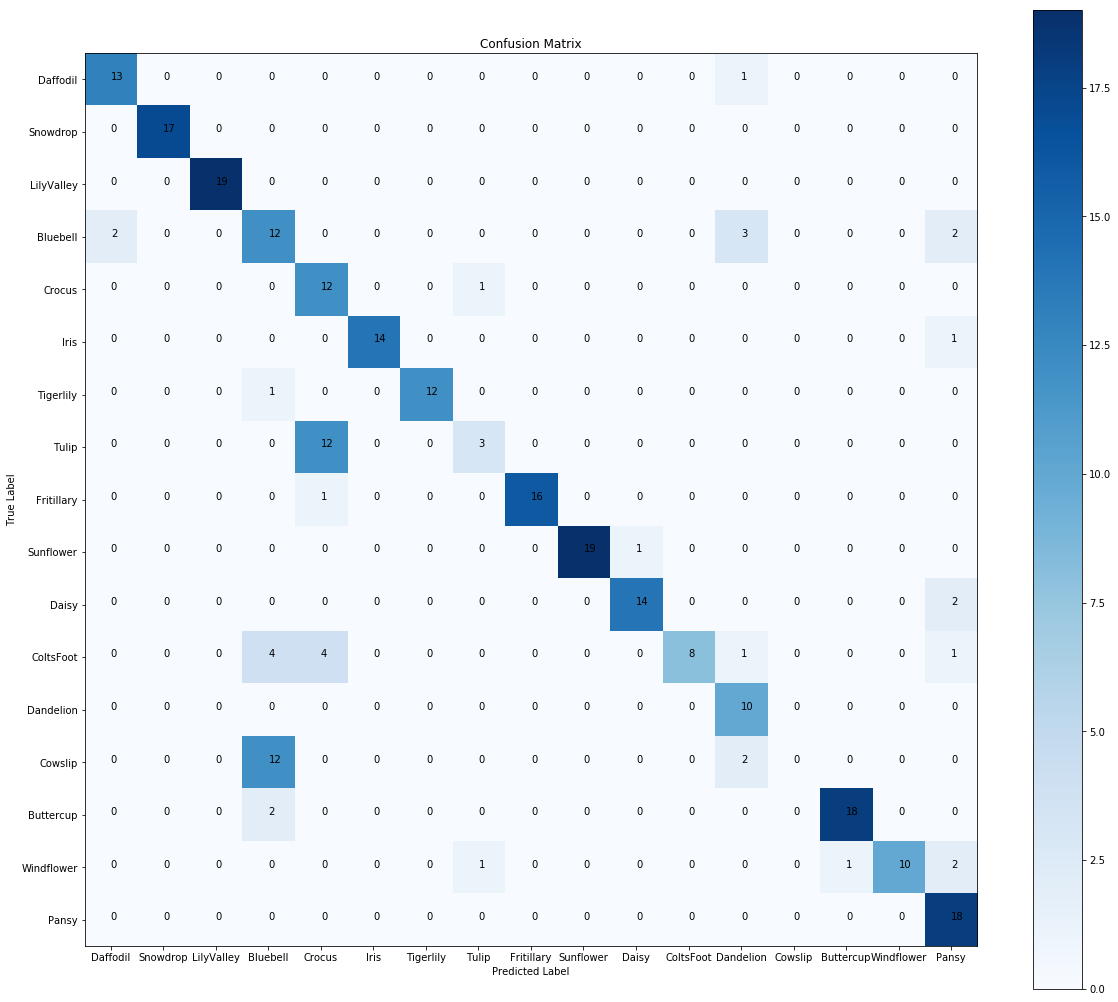

In [20]:
plt_model(test_y,pre_y.ravel(),new_label)